# Credit card applications


# Introduction

Banks receive a lot of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). 

This task can be automated with the power of machine learning. In this project, I will build an automatic credit card approval predictor using machine learning techniques.

The data set used for this project is the Credit Card Approval dataset from the UCI Machine Learning Repository. The structure of this notebook is as follows:

First, I will start off by loading and viewing the dataset. In loading and viewing the dataset I find that since this data is confidential, the contributor of the dataset has anonymized the feature names.

The dataset has a mixture of both numerical and non-numerical features, it contains values from different ranges and it also contains a number of missing entries.

I will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.

After our data is in good shape, we will do some exploratory data analysis to build our intuitions.
Finally, I will build a machine learning model that can predict if an individual's application for a credit card will be accepted.


# Install and Import relevant Libraries

In [1]:
#!pip install scikit_learn

In [2]:
#!pip install imblearn

In [3]:
# Importing Libraries for data handling
import numpy as np
import pandas as pd

# Importing Libraries for Visualisation 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Importing Libraries for Preprocesing dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Importing Libraries for Model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Importing Libraries for Model performance
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,classification_report
from sklearn.metrics import average_precision_score,recall_score

# Importing Libraries to boost Model performance
from sklearn.model_selection import GridSearchCV

In [4]:
#Load the dataset into a dataframe
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data", header = None)

## Inspecting the dataset

<p> After initially loading and inspecting the data, the output appeared a bit confusing. The features of this dataset have been anonymized to protect the privacy, but after a little bit of research, I was able to get a blog that gave a pretty good overview of the probable features. 
    
The probable features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. This gives us a pretty good starting point, and we can map these features with respect to the columns in the output.   </p>
<p>As we can see from our first glance at the data, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.</p>

In [5]:
#Rename the header for each column
df.columns = ['Male', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed',
              'PriorDefault','Employed', 'CreditScore', 'DriversLicense','Citizen', 'Zipcode', 'Income', 'Approved']

In [6]:
#print the first 5 rows in the dataset
df.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Zipcode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [7]:
# Print DataFrame information
df.info()


#get unique
df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  Zipcode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


Male                3
Age               350
Debt              215
Married             4
BankCustomer        4
EducationLevel     15
Ethnicity          10
YearsEmployed     132
PriorDefault        2
Employed            2
CreditScore        23
DriversLicense      2
Citizen             3
Zipcode           171
Income            240
Approved            2
dtype: int64

In [8]:
#Convert the age to column to a numeric
df.Age = pd.to_numeric(df.Age, errors='coerce')

#map the characters in Approved column to 0 and 1.
df.Approved = df.Approved.map({'-':0,'+':1}).astype(int)

#### Handling missing values (part i)
<p>I've uncovered some issues that will affect the performance of my machine learning model(s) if they go unchanged:</p>
<ul>
<li>The dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features Debt, YearsEmployed, CreditScore and Income contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values. I have however also changed the Age column to a numeric column and assigned the characters in the Approved column to values 0 (for No) and 1 (for Yes).</li>
    
<li>The dataset also contains values from several ranges. Some features have a value range of 14 - 80, 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which I'll take care of in this task. The missing values in the dataset are labeled with '?'.</li>
</ul>
<p>I will temporarily replace these missing value question marks with NaN.</p>

In [9]:
# Replace the '?'s with NaN
df = df.replace('?', np.NaN)

#Check for missing values
df.isnull().sum()

Male              12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
Zipcode           13
Income             0
Approved           0
dtype: int64

# Analyzing Numerical Variables and Data Imputation


Before imputing the missing data, it is better to see the histogram of the variables first. We will use the histplot() function of Seaborn package. Also Matplotlib’s vlines() function is used for the vertical lines (mean, median and mode of age variable) in the graph. Mean, Median and Mode are the most commonly used central tendency metrics.

One can choose between mean, median and mode. I will go for the mean as it is the closest to the shape of the age distribution and does not distort the shape of the distribution as much as mode and median. 

Mean, median and mode imputation scenarios are visualised in the comparison graph below.



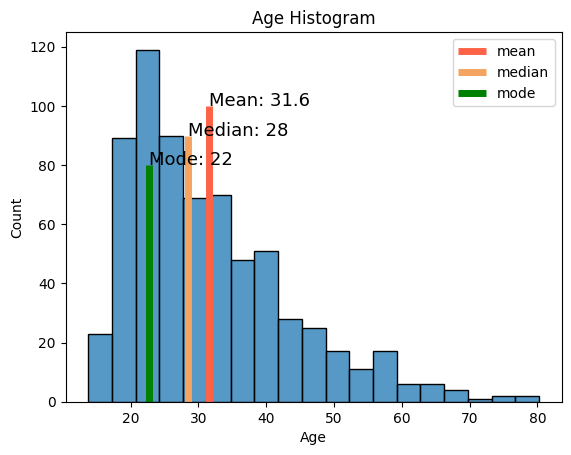

In [10]:
#fill the age column with mean median and mode and visualize
age_mean = df.Age.mean()
age_median = df.Age.median()
age_mode = df.Age.mode()[0]

plt.figure()
sns.histplot(df.Age)
plt.vlines(x = age_mean, label = "mean", linewidth = 5, color = 'tomato', ymin =0, ymax =100)
plt.vlines(x = age_median, label = "median", linewidth = 5, color = 'sandybrown', ymin =0, ymax =90)
plt.vlines(x = age_mode, label = "mode", linewidth = 5, color = 'green', ymin =0, ymax =80)
plt.text(age_mean, 100, f"Mean: {round(age_mean, 1)}", fontsize =13)
plt.text(age_median, 90, f"Median: {int(age_median)}", fontsize =13)
plt.text(age_mode, 80, f"Mode: {int(age_mode)}", fontsize =13)
plt.title("Age Histogram")
plt.legend()
plt.show()

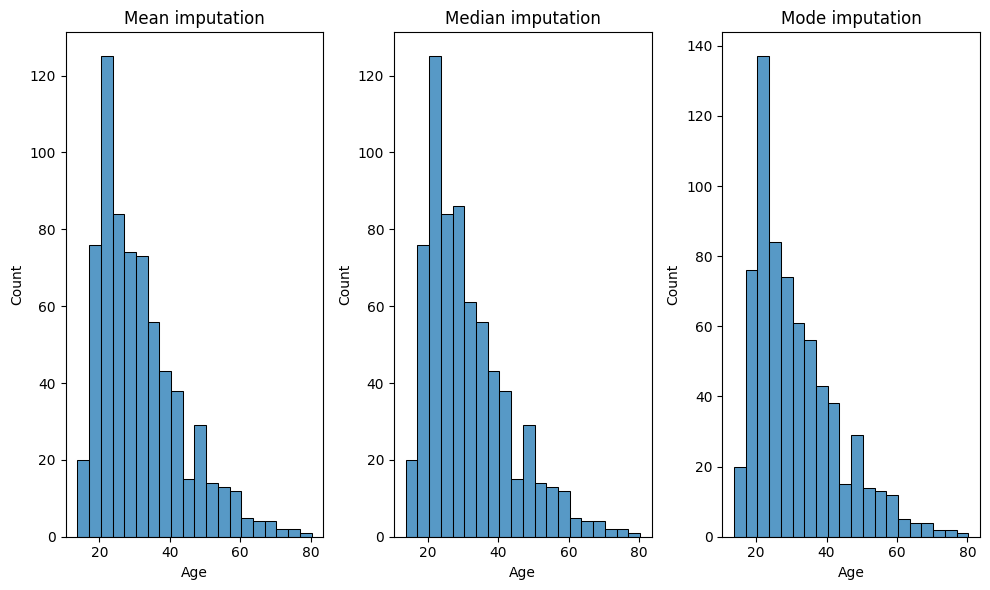

In [11]:
#Fill the missing values in Age column with the mean, median and mode
filled_mean = df.Age.fillna(age_mean).copy()
filled_median = df.Age.fillna(age_median).copy()
filled_mode = df.Age.fillna(age_mode).copy()

fig, ax = plt.subplots(1,3, figsize= (10,6))
sns.histplot(filled_mean, ax = ax[0])
ax[0].set_title("Mean imputation")
sns.histplot(filled_median, ax = ax[1])
ax[1].set_title("Median imputation")
sns.histplot(filled_mode, ax = ax[2])
ax[2].set_title("Mode imputation")
plt.tight_layout()
plt.show()




In [12]:
#impute the missing vzlue using mean imputation
df.Age = filled_mean.copy()

In [13]:
#get summary tatistics of the numeric columns
df.describe()

,Age,Debt,YearsEmployed,CreditScore,Income,Approved
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,1017.385507,0.444928
std,11.853273,4.978163,3.346513,4.86294,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.670000,1.000000,0.165000,0.00000,0.000000,0.000000
50%,28.625000,2.750000,1.000000,0.00000,5.000000,0.000000
75%,37.707500,7.207500,2.625000,3.00000,395.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,100000.000000,1.000000


Now that I have an understanding of how this variable is distributed, I will compare the credit status by value of numerical features. I’ll use a boxplot. From the boxplot (Age), the median of the two groups is slightly different with the age of approved applications being slightly closer to the mean than the denied applications. We can also see that the interquartile range is greater on the ‘Approved’ than the others. We can interpret these facts as the credit applicants with lower Age values are less likely to be granted credit, however there are several outlying applicants with high values that still were not granted credit.

The charts below show the continuous variables after first taking the log of each value. We should specifically notice for the Income and CreditScore variables it seems a low Income or CreditScore score is likely a good predictor for making the application decision.

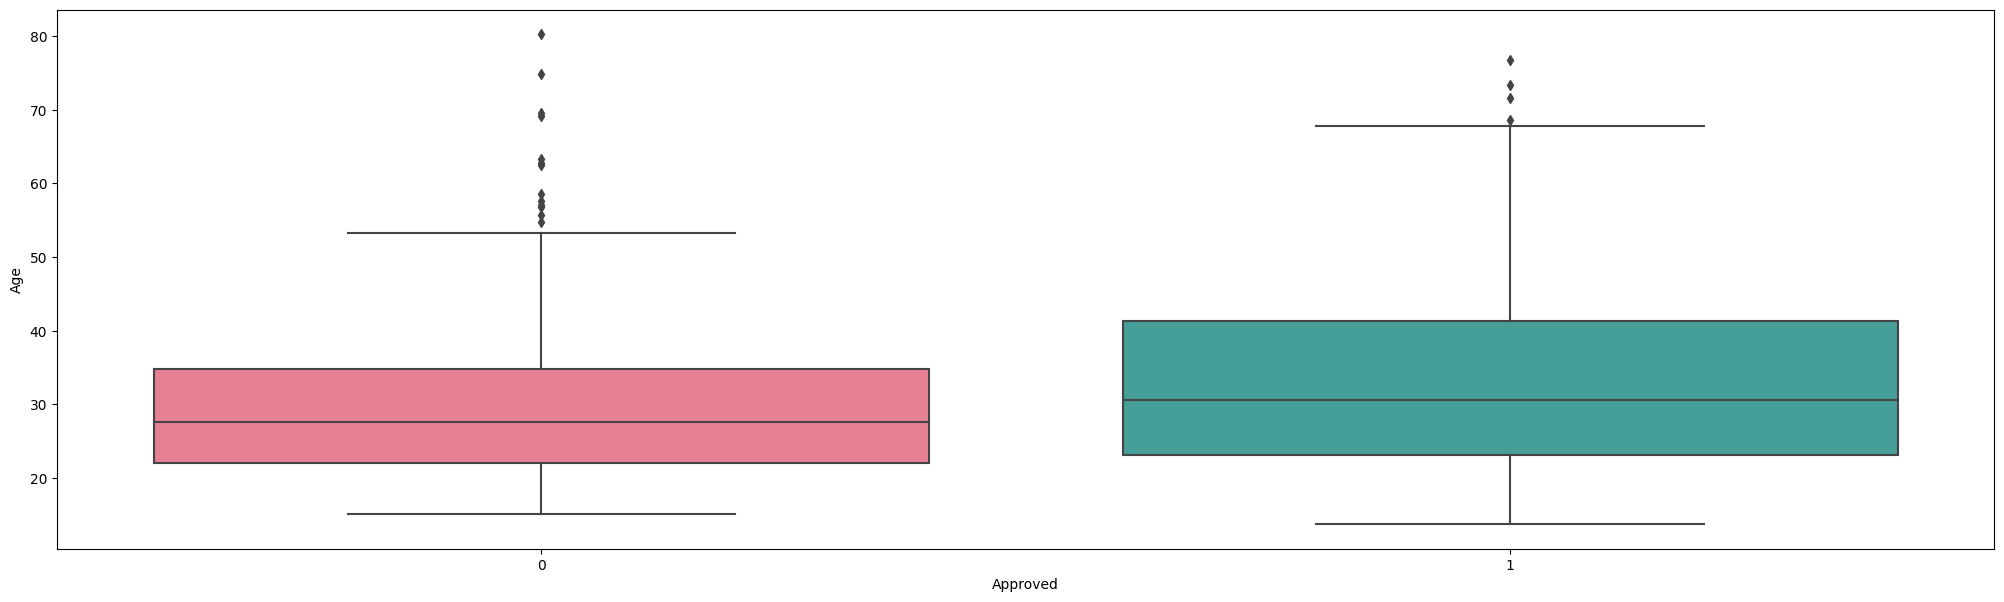

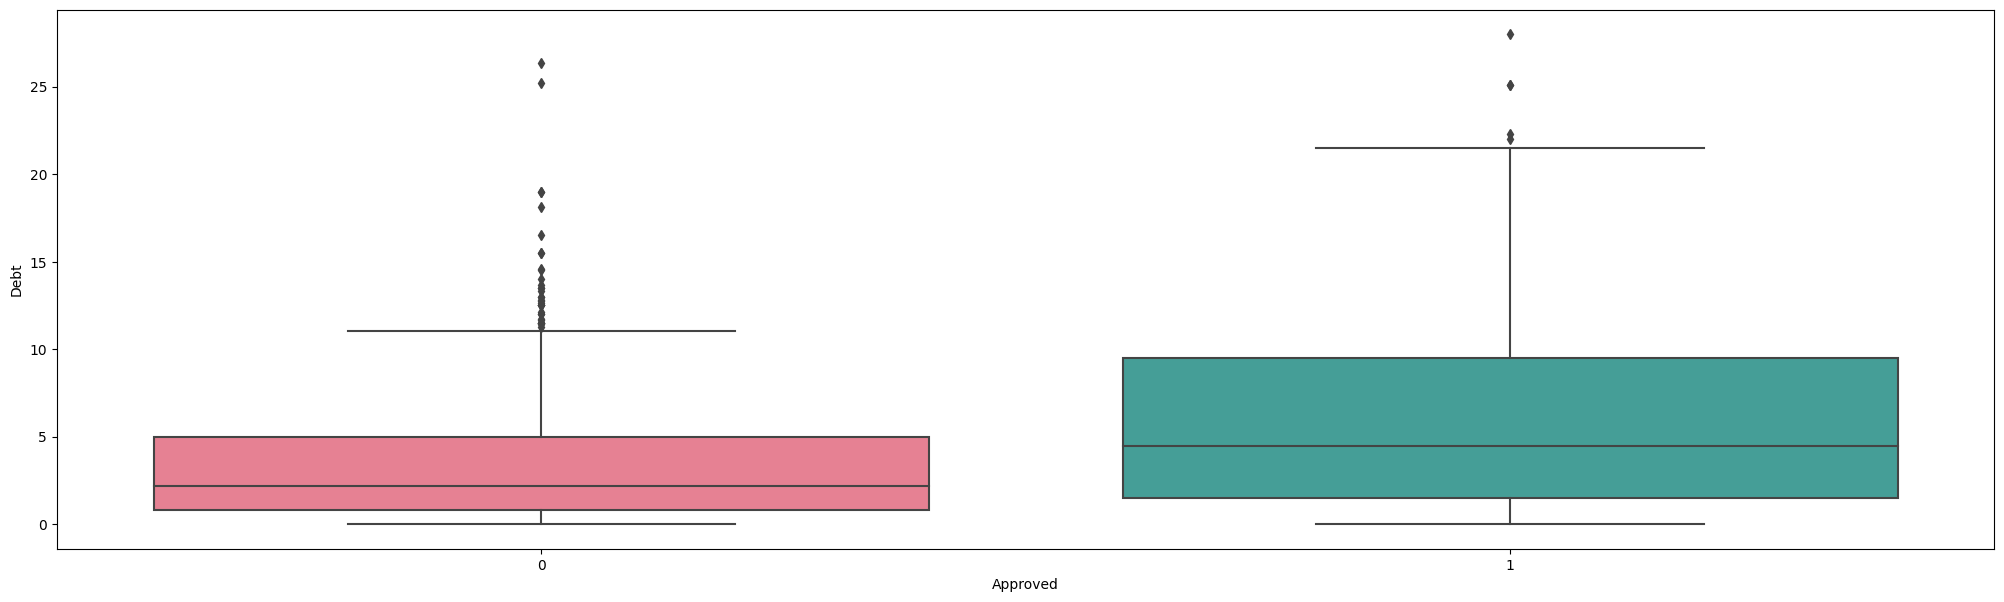

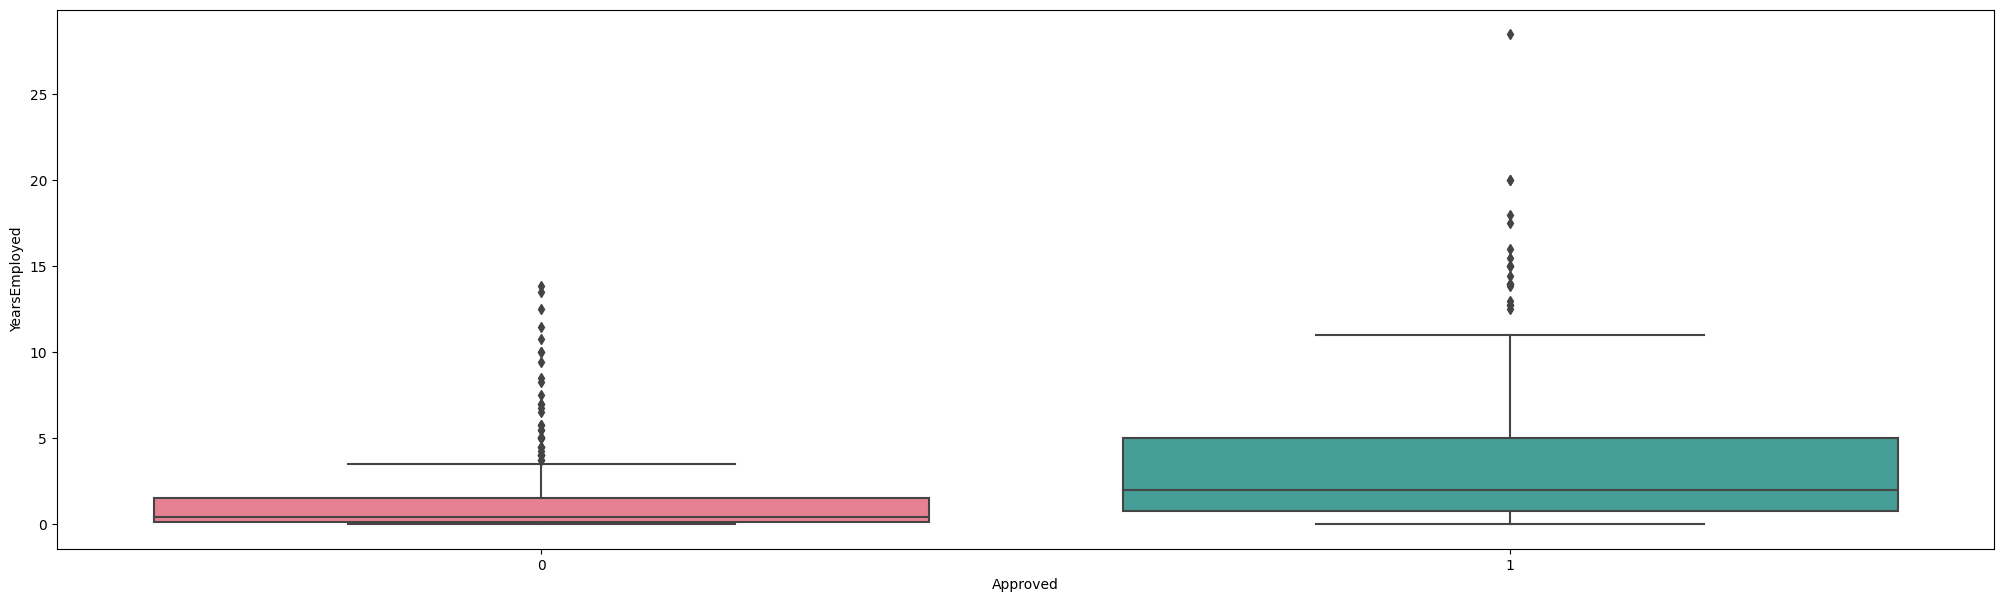

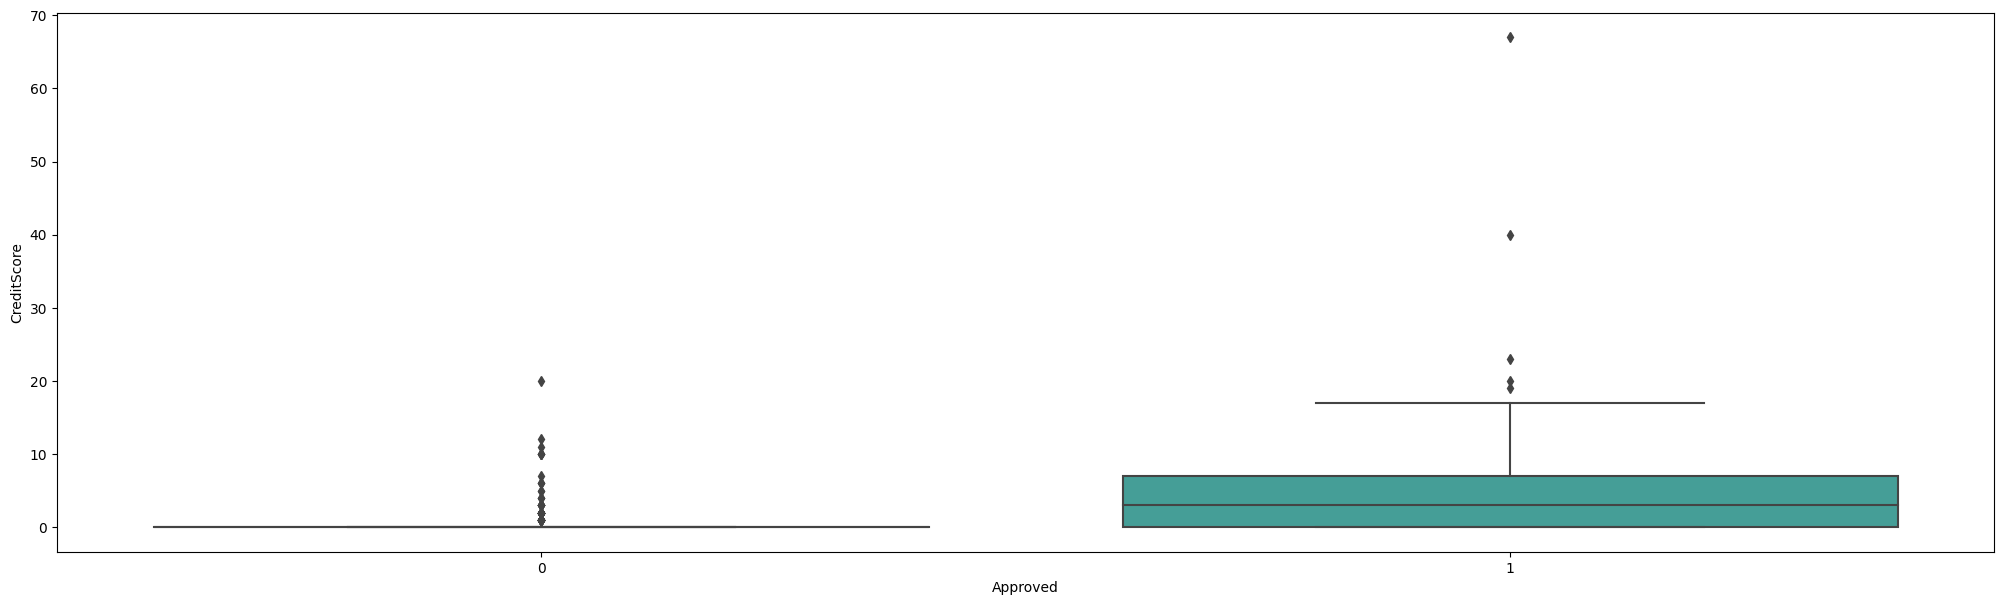

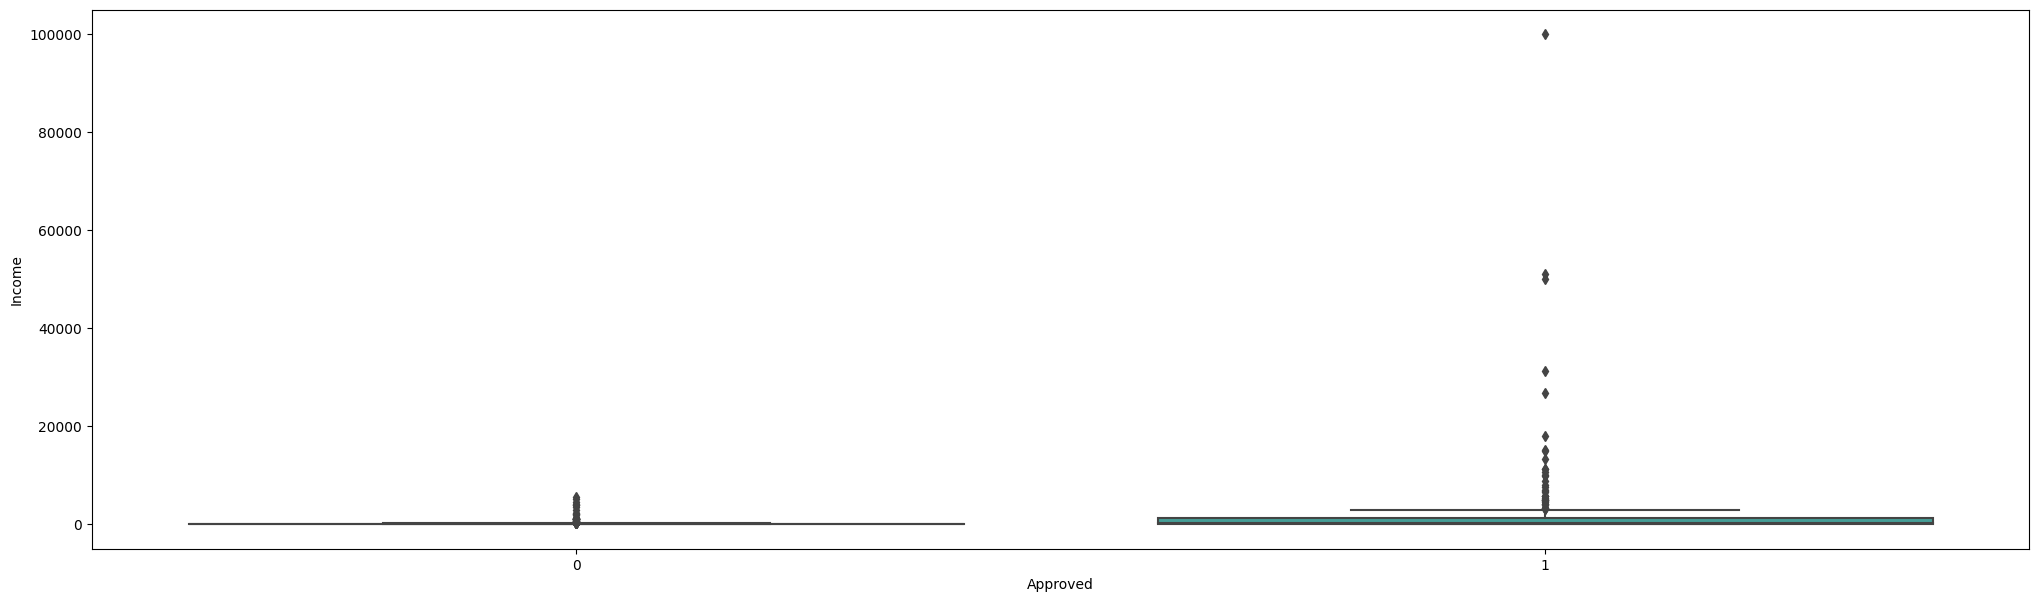

In [14]:
num_var = ['Age','Debt', 'YearsEmployed', 'CreditScore', 'Income']
for col in num_var:
    fig = plt.figure(figsize=(25,7)) #set plot size
    sns.boxplot(data =df, x= 'Approved',y= col, palette ='husl')

# Analyzing the categorical columns and missing value imputation

Text(0.5, 1.0, 'Percentage of credit card approvals')

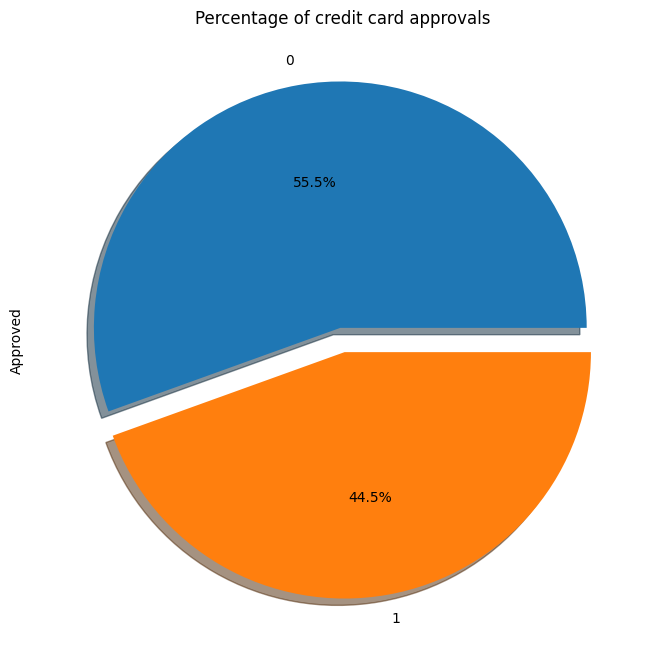

In [15]:
#Get percentage of credit approvals
df['Approved'].value_counts().plot.pie(explode= [0.05, 0.05], autopct = '%1.1f%%', shadow=True, figsize=(10,8))
plt.title('Percentage of credit card approvals')

In [16]:
# Iterate over each column of df
for col in df:
    # Check if the column is of object type
    if df[col].dtypes == 'object':
        # Impute with the most frequent value
        df = df.fillna(df[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
df.isnull().sum()

Male              0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
Zipcode           0
Income            0
Approved          0
dtype: int64

I will be converting all the non-numeric values into numeric ones. This will be done using Label encoding

In [17]:
le = LabelEncoder()
# Iterate over all the values of each column and extract their dtypes
for col in df:
    # Compare if the dtype is object
    if df[col].dtypes=='object':
    # Use LabelEncoder to do the numeric transformation
        df[col]=le.fit_transform(df[col])

<AxesSubplot:>

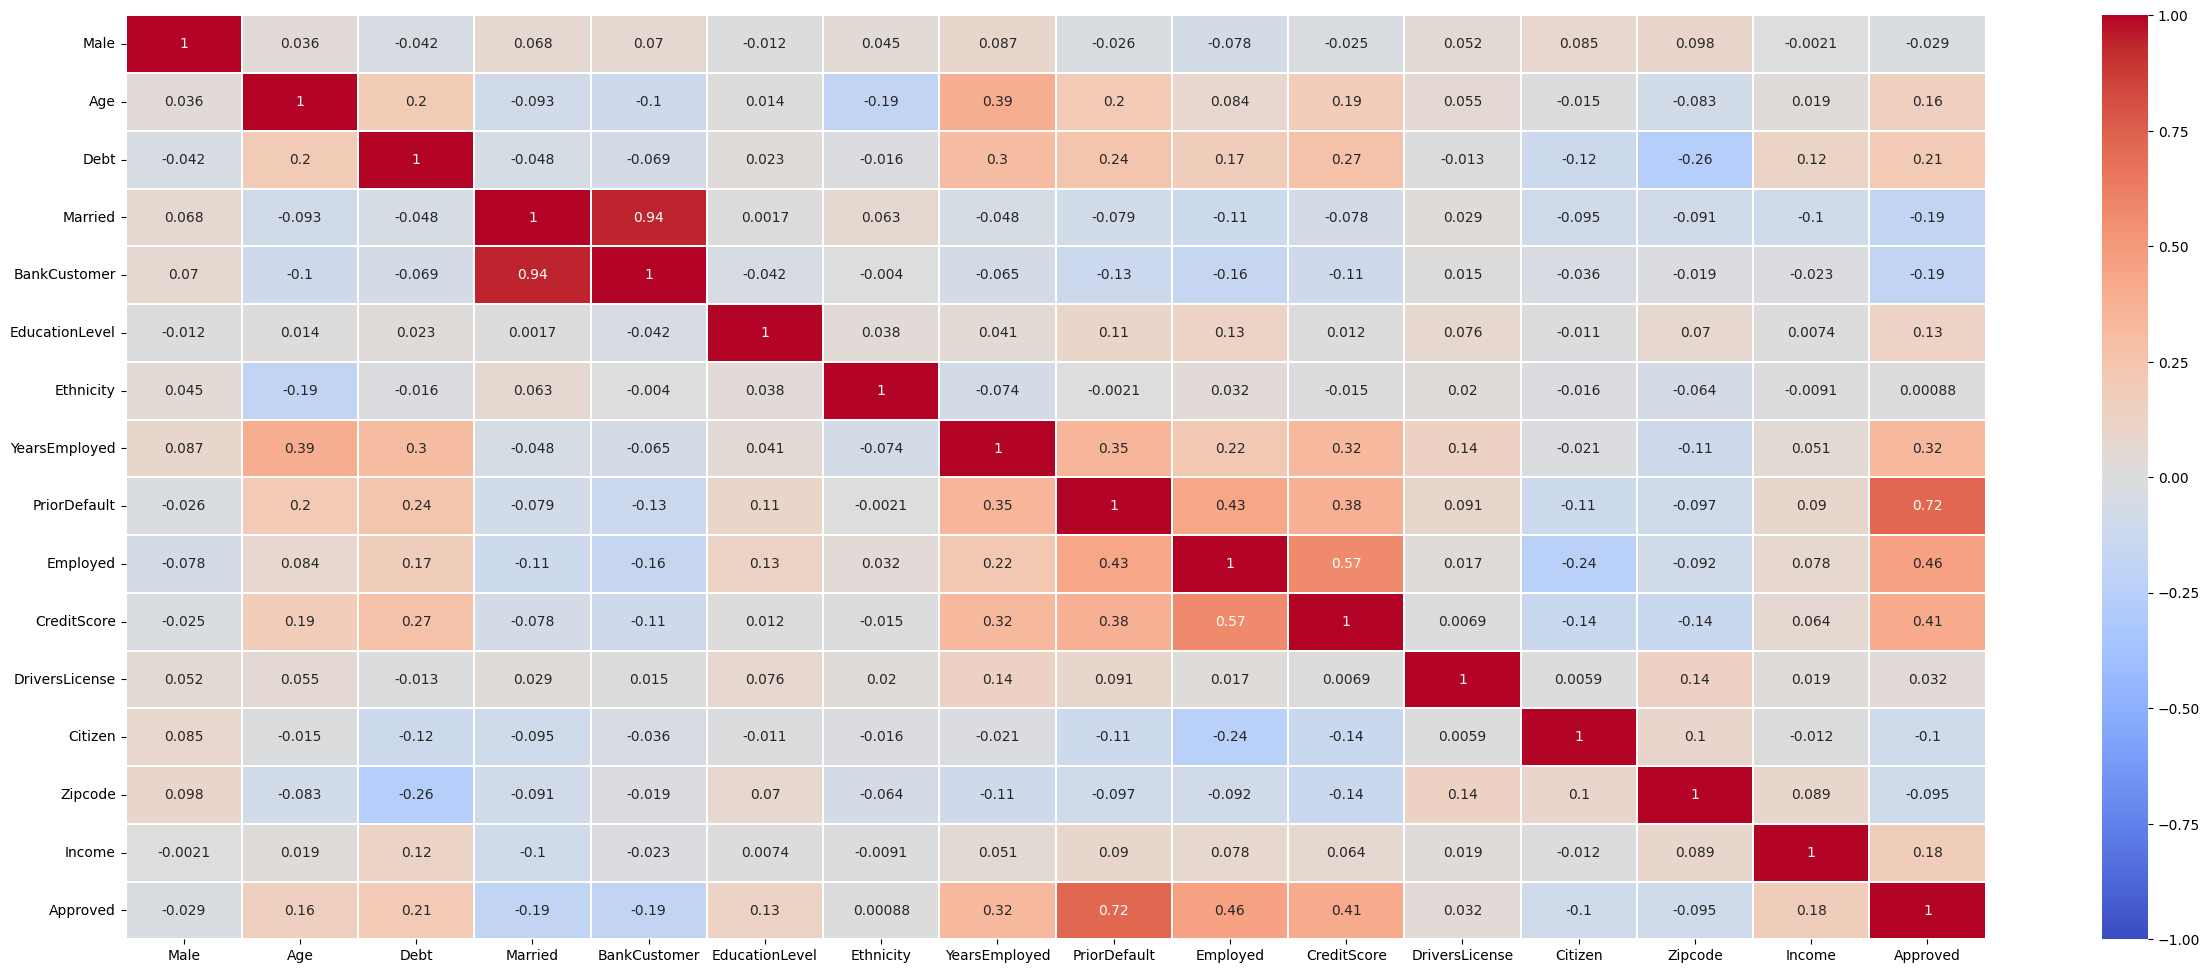

In [18]:
# set plot size
plt.figure(figsize=(30, 12))

#create correlation data frame
#corr = dummy_df.corr()
corr = df.corr()
# plot heat map of correlation data frame
sns.heatmap(corr, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [19]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [20]:
corr_features = correlation(df, 0.7)
len(set(corr_features))

2

In [21]:
corr_features

{'Approved', 'BankCustomer'}

In [22]:
#drop features that are not important in predicting Creditv card approval

X = df.drop(['Approved','BankCustomer', 'Zipcode', 'DriversLicense'], axis =1)
y = df['Approved']


In [23]:
#load and split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((552, 12), (138, 12))

In [24]:
#From the EDA, It was clear that the data set was imbalanced, hence I would do oversampling to balance it
# Oversampling but train and test data set
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
X_test, y_test = SMOTE().fit_resample(X_test, y_test)

In [25]:
# check that oversampling was successful using value count on dependent variable
y_train.value_counts()

0    315
1    315
Name: Approved, dtype: int64

In [26]:
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

## Baseline Model

Once the dataset has been split, I can establish a baseline model for predicting whether a credit application will be approved. This baseline model will be used as a benchmark to determine how effective the models are. First, we determine the percentage of credit card applications that were approved in the training set: There are 690 applications and 383 or 55.5% of which were denied. Since more applications were denied than were approved, our baseline model will predict that all applications were denied. This simple model would be correct 55.5% of the time. Our models have to be more accurate than 55.5% to add value to the business.


# Logistic regression

In [27]:
LR = LogisticRegression()
#train the model on train set
LR.fit(rescaledX_train, y_train)

LogisticRegression()

In [28]:
#predict
y_pred = LR.predict(rescaledX_test)

In [29]:
LR_acc = accuracy_score(y_test, y_pred)
print(LR_acc)
LR_conf_mat = classification_report(y_test, y_pred)
print(LR_conf_mat)

0.8214285714285714
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        70
           1       0.79      0.87      0.83        70

    accuracy                           0.82       140
   macro avg       0.82      0.82      0.82       140
weighted avg       0.82      0.82      0.82       140



In [30]:
LR_f1 = f1_score(y_test, y_pred)
LR_f1

0.8299319727891157

# Random Forest

In [31]:
RFC = RandomForestClassifier()
RFC.fit(rescaledX_train, y_train)
#predict
y_pred = RFC.predict(rescaledX_test)

RFC_acc = accuracy_score(y_test, y_pred)
print("The accuracy score is : {}".format(RFC_acc))

The accuracy score is : 0.8571428571428571


In [32]:
RF_F1 = f1_score(y_test, y_pred)

print("The F1 score is : {}".format(RF_F1))

The F1 score is : 0.8571428571428571


# Decision Tree Classifier

In [33]:
DTC = DecisionTreeClassifier()
DTC.fit(rescaledX_train, y_train)
#predict
y_pred = DTC.predict(rescaledX_test)

DTC_acc = accuracy_score(y_test, y_pred)
print("The accuracy score is : {}".format(DTC_acc))


The accuracy score is : 0.8214285714285714


In [34]:
DTC_F1 = f1_score(y_test, y_pred)
print("The F1 score is : {}".format(DTC_F1))

The F1 score is : 0.8148148148148148


# Support Vector Classifier

In [35]:
svc = SVC()
svc.fit(rescaledX_train, y_train)
#predict
y_pred = svc.predict(rescaledX_test)

svc_acc = accuracy_score(y_test, y_pred)
print("The accuracy score is : {}".format(svc_acc))

The accuracy score is : 0.8357142857142857


In [36]:
SVC_F1 = f1_score(y_test, y_pred)

print("The F1 score is : {}".format(SVC_F1))

The F1 score is : 0.8413793103448276


# Model Performance

It is more costly to a bank or financial institution to give money to a bad customer than to not give money to a good customer. We will take this into account when selecting a performance metric. Therefore the performance metric I will use is the F1 score.

# Explaining other performance metrics for classification problems

- F1 score: The harmonic mean of the model's precision and recall and this is my main basis for evaluation
- Accuracy score: the ratio of correct predictions to total number of observation

Logistic Regression    0.829932
Random Forest          0.857143
Decission Tree         0.814815
SVC                    0.841379
dtype: float64


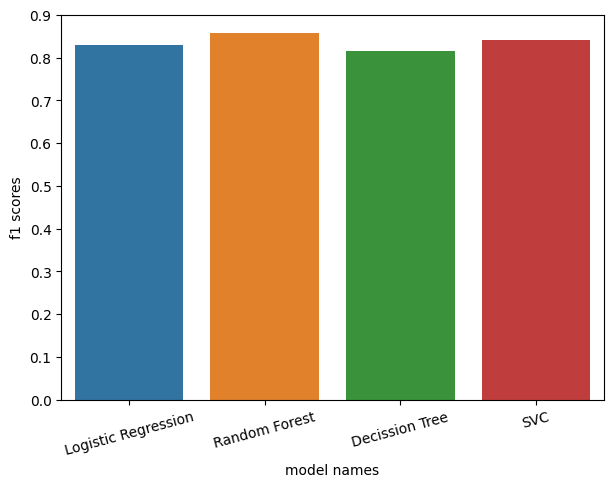

In [37]:
#collate all f_1 score into a pandas series before plotting
model_f1 = pd.Series(data = [LR_f1, RF_F1,DTC_F1, SVC_F1],
                     index = ['Logistic Regression', 'Random Forest', 'Decission Tree', 'SVC'])
print(model_f1)


fig, ax = plt.subplots(figsize =(7,5))
sns.barplot(x = model_f1.index, y = model_f1, ax =ax)
plt.xlabel('model names') #add ylabel
plt.ylabel('f1 scores') # add xlabel
plt.xticks(rotation=15) #rotate xlabels to fit
plt.show()

# Hyper parameter tuning with GridSearchCV

In [38]:
# declaring an object for the classifier
RFC = RandomForestClassifier()

# set hyper parameters

param_grid = {'n_estimators': [100, 600],
             'min_samples_split': [3],
             'random_state': [7,10],
             'random_state': [5,42]}

In [39]:
# grid search estimator
grid = GridSearchCV(RFC, param_grid=param_grid,
                   cv=5, scoring='f1',
                   return_train_score=True)

In [40]:
#train grid
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': [3], 'n_estimators': [100, 600],
                         'random_state': [5, 42]},
             return_train_score=True, scoring='f1')

In [41]:
#best parameters
print(grid.best_params_)

{'min_samples_split': 3, 'n_estimators': 600, 'random_state': 5}


In [42]:
# get best score
grid.best_score_

0.8850694405316955

The hyper-parameter improved the score, but to the fair the score pretty high already

In [43]:
#to be deployed to webapp, use unscaled data

U_RFC = RandomForestClassifier(min_samples_split= 3, n_estimators =600, random_state = 5)
U_RFC.fit(X_train, y_train)
#predict
y_pred = U_RFC.predict(X_test)

U_RFC_acc = accuracy_score(y_test, y_pred)
print("The accuracy score is : {}".format(U_RFC_acc))

U_RF_F1 = f1_score(y_test, y_pred)
print("The F1 score is : {}".format(U_RF_F1))


The accuracy score is : 0.8642857142857143
The F1 score is : 0.8633093525179856


In [44]:
# saving the model 
import pickle

In [52]:
#filename = 'test.sav'
pickle_out = open("classify.pkl", "wb") 
pickle.dump(U_RFC, pickle_out)
pickle_out.close()

In [53]:
loaded_model = pickle.load(open('classify.pkl', 'rb'))

In [54]:
    input_data = (1,24.58,13.5,3,6,3,0,0,0,0,0,0) #test to make sure the loaded model wprks fine
    input_data_as_numpy_array = np.asarray(input_data)

    input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

    prediction = loaded_model.predict(input_data_reshaped)
    print(prediction)

    if (prediction[0] == 0):
        print ("Rejected")
    else:
        print ("Approved")

[0]
Rejected


/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Key areas for further research and testing

- unscramble the data to make more sense of it
- Use association rules to fill in missing categorical variables 
- Carry out more EDA to find relationship between variables and test hypothesis to find the factors that most contribute in the credit card approval decision making.
- Speak with industry experts to better understand the data.